In [60]:
import time
from jax import random
import test
import plots
import ntk
import nll
from jax import numpy as np
import pickle
import models
import utils
from matplotlib import pyplot as plt
import dataset_sines_infinite
import dataset_sines_finite
import dataset_step_infinite
from ntk import get_kernel_and_jac_identity_cov
import optax
import train_states
import jax
from jax import value_and_grad
from jax import pmap
from jax import lax
from jax import jit
from jax import vmap
from jax import scipy

In [61]:
seed = 1655235988902897757
print(seed)

1655235988902897757


In [135]:
def gaussian_posterior_full(kernel, kernel_self, x_a, y_a, x_b, maddox_noise):
    """
    Computes the gaussian posterior with this kernel and this data, on the queried inputs.
    x_a is a (batch_size, input_dims) array (! has lost n_tasks)
    y_a is a (batch_size, reg_dim) array (! has lost n_tasks)
    Returns the posterior covariance matrix
    """
    dim = y_a.shape[1]
    y_a = np.reshape(y_a, (-1,))

    cov_a_a = kernel(x_a, x_a)
    cov_a_a = cov_a_a + maddox_noise ** 2 * np.eye(cov_a_a.shape[0])
    cov_b_a = kernel(x_b, x_a)
    cov_b_b = kernel(x_b, x_b)

    print(cov_a_a.shape)
    print(cov_b_a.shape)
    print(cov_b_b.shape)

    L = scipy.linalg.cho_factor(cov_a_a)
    alpha = scipy.linalg.cho_solve(L, y_a)
    post_mean = cov_b_a @ alpha
    
    v = scipy.linalg.cho_solve(L, cov_b_a.T)
    post_cov = cov_b_b - cov_b_a @ v
    
    return np.reshape(post_mean, (-1, dim) ), post_cov

In [136]:
def plot_gpr(x_a_all, y_a_all, x_b, y_b, kernel, kernel_self, K, dataset_provider):
    """
    Make an informative prediction plot in the singGP case (for the kernel specified)
    K is the number of context inputs
    Change dataset_provider to test on other datasets (e.g. dataset_sines_infinite)
    """
    y_min, y_max = np.min(y_b) - 0.5, np.max(y_b) + 0.5

    x_a = x_a_all[:K]
    y_a = y_a_all[:K]
    prediction, cov = gaussian_posterior_full(kernel, kernel_self, x_a, y_a, x_b, 0.05)

    error = dataset_provider.error_fn(prediction, y_b)
    loss = nll.nll(kernel_self, x_a, y_a, maddox_noise=0.05)

    variances = np.diag(cov)
    stds = np.sqrt(variances)

    plt.plot(x_b, y_b, "g--", label="Target")
    plt.plot(x_a, y_a, "ro", label="Context data")
    plt.plot(x_b, prediction, "b", label="Prediction")
    plt.fill_between(x_b[:, 0], prediction[:, 0] - 1.96 * stds, prediction[:, 0] + 1.96 * stds, color='blue', alpha=0.1, label="+/- 1.96$\sigma$")
    plt.title(f"NLL={loss:.4f}, MSE={error:.4f} ($K$={K})")
    plt.legend()
    plt.gca().set_ylim([np.min(prediction), np.max(prediction)])
    plt.gca().set_xlabel("$x$")
    plt.gca().set_ylabel("$y$")
    plt.legend()

In [137]:
def kernel(x1, x2):
    # Ensure x1 and x2 are broadcastable to shape (100, 10, 1)
    # x1 shape: (100, 1, 1) by adding a new axis
    # x2 shape: (1, 10, 1) by adding a new axis at the beginning
    x1 = x1[:, np.newaxis, :]
    x2 = x2[np.newaxis, :, :]

    # Now x1 and x2 are compatible for broadcasting
    # Compute squared Euclidean distance
    squared_diff = (x1 - x2) ** 2
    return np.exp(-np.mean(squared_diff, axis=-1))

# Apply vmap to vectorize kernel function over pairs of inputs
kernel_matrix = vmap(vmap(kernel, in_axes=(None, 0)), in_axes=(0, None))

In [138]:
key = random.PRNGKey(0)

(10, 10)
(100, 10)
(100, 100)


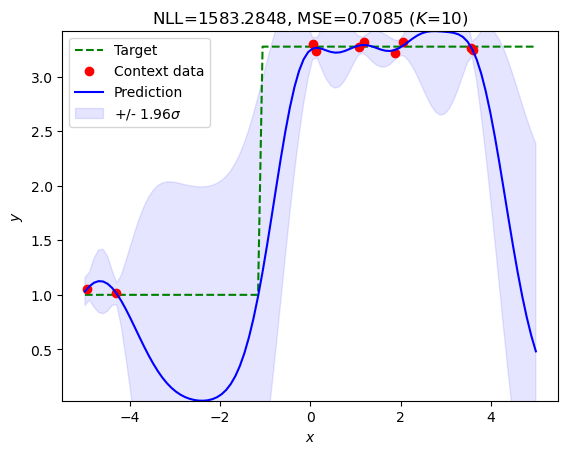

In [139]:
x, y, fun = dataset_step_infinite.get_fancy_test_batch(key, K=10, L=0, data_noise=0.05)

x_a_all = x[0, :10]
y_a_all = y[0, :10]
x_b = np.linspace(-5, 5, 100)[:, np.newaxis]
y_b = fun(x_b)

plot_gpr(x_a_all, y_a_all, x_b, y_b, kernel, kernel_self, 10, dataset_sines_infinite)